<h1>The Battle of Neighborhoods - Identification of Filipino Speaking Population and Opportunities for Business and Employment

<h2>Install necessary components

In [1]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium --yes 
!conda install -c conda-forge pyquery --yes
!conda install -c conda-forge geocoder --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    certifi-2018.10.15         |        py36_1000         138 KB  conda-forge
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0            conda-forge
    geopy:           

<h2>Get information on geographic location and characterize demographics

In [5]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
wikitables = soup.find_all('table') 
Toronto = pd.read_html(str(wikitables[0]), index_col=None, header=0)[0]
Toronto.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [6]:
# TO VERIFY THAT BOTH METHODS PRODUCE SIMILAR DIMENSIONS
Toronto.shape

(289, 3)

In [7]:
# Empty entries to np.nan to drop them in the next step
Toronto['Borough'].replace('', np.nan, inplace=True)
# Drop np.nan to remove rows not containing meaningful data
Toronto.dropna(subset=['Borough'], inplace=True)
# Leave behind rows containing 'Not assigned' in 'Borough'
Toronto = Toronto[Toronto['Borough'] != 'Not assigned']

In [8]:

# Iterate over the dataframe and fix 'Not assigned' for column 'Neighborhood'
for i, _ in Toronto.iterrows():
    if Toronto.loc[i]['Neighbourhood'] == 'Not assigned': Toronto.loc[i]['Neighborhood'] = Toronto.loc[i]['Borough']

In [9]:
# Check datafame shape
Toronto.shape

(212, 3)

In [10]:
# Print the number of rows in the dataframe
print('Number of rows in Toronto dataframe: {}'.format(Toronto.shape[0]))

Number of rows in Toronto dataframe: 212


In [11]:
TPS = Toronto['Postcode'].unique()
len(TPS)

103

In [12]:
!wget -q --no-check-certificate -O 'latitude.pickle' 'https://docs.google.com/uc?export=download&id=1PdEOkPErrpBtDgSlDwczIv_KLlpY-YcO'
!wget -q --no-check-certificate -O 'longitude.pickle' 'https://docs.google.com/uc?export=download&id=1XujA04dCARQnlxu-X2ItOVcYQz0MMQh9'

In [13]:
!ls -l *.pickle

-rw-rw-r-- 1 jupyterlab resources 1965 Nov 29 17:23 latitude.pickle
-rw-rw-r-- 1 jupyterlab resources 1965 Nov 29 17:23 longitude.pickle


In [14]:
import pickle

with open('latitude.pickle', 'rb') as flat:
    latitude = pickle.load(flat)
with open('longitude.pickle', 'rb') as flon:
    longitude = pickle.load(flon)

In [15]:
import geocoder
import time

for postcode in TPS:
    # When offline cache is available use it to avoid Geocoder Google API throttling
    if postcode in latitude.keys(): 
        continue
    while True:
        g = geocoder.google('{}, Toronto, Ontario'.format(postcode))
        lat_lng_coords = g.latlng
        if lat_lng_coords == None:
            print('Trottled response to {}'.format(postcode))
            time.sleep(5)
            continue
        break
    
    if lat_lng_coords != None:
        latitude[postcode] = lat_lng_coords[0]
        longitude[postcode] = lat_lng_coords[1]
print('Successfully populated geo locations')


Successfully populated geo locations


In [16]:
lat = []
lon = []
for i, _ in Toronto.iterrows():
    lat.append(latitude[Toronto.loc[i]['Postcode']])
    lon.append(longitude[Toronto.loc[i]['Postcode']])

In [17]:
Toronto = Toronto.assign(Latitude = lat, Longitude=lon)
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
6,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [18]:
Toronto = Toronto.reset_index(drop=True)
Toronto.to_csv('Toronto.csv')
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [19]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import numpy as np
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [20]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
soup = BeautifulSoup(res.content,'lxml')
wikitables = soup.find_all('table') 
Toronto_Demographics = pd.read_html(str(wikitables[1]), index_col=None, header=0)[0]

In [21]:
Toronto_Demographics.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


In [22]:
df_dens = pd.DataFrame(Toronto_Demographics[['Name','Land area (km2)', 'Average Income', 'Density (people/km2)', 'Population', '% Change in Population since 2001']])
df_dens.drop([0], inplace=True)
df_dens.rename(columns={'% Change in Population since 2001': 'Change'}, inplace=True)
df_dens = df_dens.reset_index(drop=True)
df_dens.set_index(['Name'], inplace=True)
df_dens.apply(pd.to_numeric, errors='ignore')
df_dens.head()

,Land area (km2),Average Income,Density (people/km2),Population,Change
Name,,,,,
Agincourt,12.45,25750,3580,44577,4.6
Alderwood,4.94,35239,2360,11656,-4.0
Alexandra Park,0.32,19687,13609,4355,0.0
Allenby,0.58,245592,4333,2513,-1.0
Amesbury,3.51,27546,4934,17318,1.1


In [23]:
df_dens['Change'] = df_dens['Change'].apply(lambda x: x * 1000)

<Figure size 432x288 with 0 Axes>

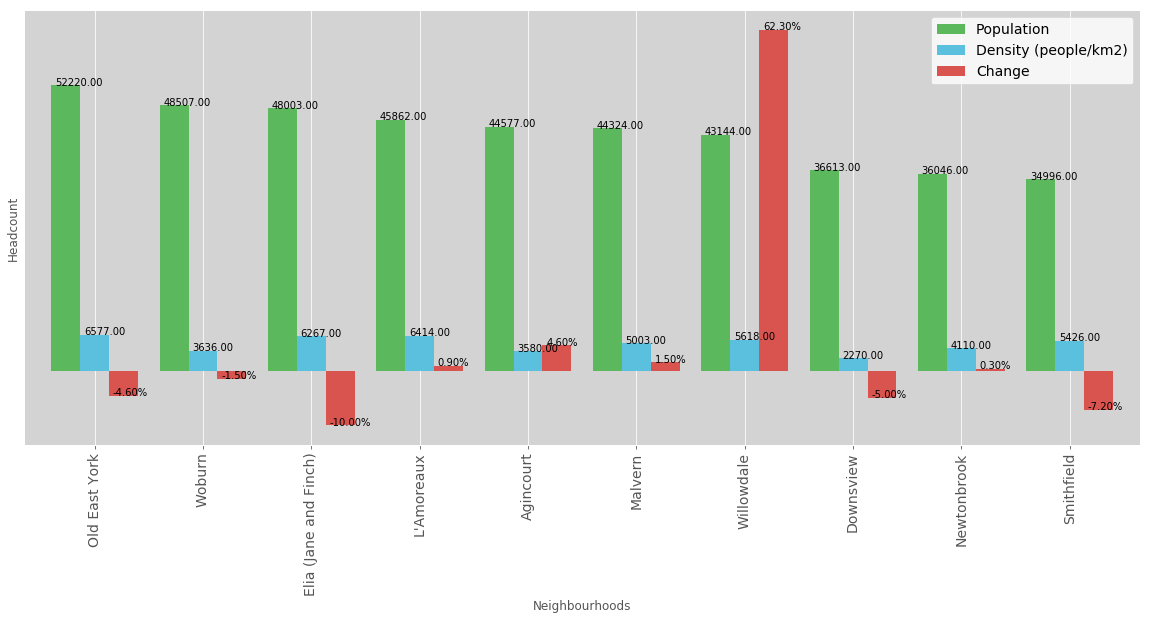

In [24]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c', '#5bc0de', '#d9534f']
df_dens = df_dens.sort_values(['Population', 'Density (people/km2)'], ascending=False)
ax = df_dens[['Population', 'Density (people/km2)', 'Change']][:10].plot(kind='bar', grid=True, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightgray')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Headcount')
plt.title('')
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "{:.2f}".format((b.y1 + b.y0) if n <=19 else (b.y1 + b.y0)/1000)
    if n > 19:
        val += '%'
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

In [25]:
columns_to_drop = [
    'FM', 
    'Census Tracts', 
    '% Change in Population since 2001', 
    'Land area (km2)', 
    'Transit Commuting\xa0%', 
    '% Renters', 
    'Second most common language (after English) by name', 
    'Map'
]

Toronto_Demographics.drop(columns=columns_to_drop, inplace=True)

Toronto_Demographics = Toronto_Demographics.rename(columns={'Second most common language (after English) by percentage':'ESL'})
Toronto_Demographics = Toronto_Demographics.rename(columns={'Name':'Neighbourhood'})
Toronto_Demographics.drop([0], inplace=True)

Toronto_Demographics.head()
Toronto_Demographics['Percentage'] = Toronto_Demographics.apply (lambda row: row['ESL'].split('% ')[0],axis=1)
Toronto_Demographics['Language'] = Toronto_Demographics.apply (lambda row: row['ESL'].split('% ')[1],axis=1)
Toronto_Demographics.drop(columns=['ESL'], inplace=True)

In [26]:
Toronto_Demographics.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
3,Alexandra Park,4355,13609,19687,17.9,Cantonese
4,Allenby,2513,4333,245592,01.4,Russian
5,Amesbury,17318,4934,27546,06.1,Spanish


In [27]:
list_of_neighbourhoods = Toronto_Demographics['Neighbourhood'].values.tolist()

In [28]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [29]:
list_missing_neigh = []
for neigh in list_of_neighbourhoods:
    if neigh not in Toronto['Neighbourhood'].values and neigh not in Toronto['Borough']:
        list_missing_neigh.append(neigh)
list_missing_neigh

['Alexandra Park',
 'Allenby',
 'Amesbury',
 'Armour Heights',
 'Banbury',
 'Bay Street Corridor',
 'Bayview Woods – Steeles',
 'Bendale',
 'Bloor West Village',
 'Bracondale Hill',
 'Branson',
 'Bridle Path',
 'Caribou Park',
 'Carleton Village',
 'Casa Loma',
 'Centennial',
 'Chaplin Estates',
 'Christie Pits',
 'Clairville',
 'Corktown',
 'Crescent Town',
 'Cricket Club',
 'Davenport',
 'Discovery District',
 'Distillery District/West Don Lands',
 'Don Mills',
 'Don Valley Village',
 'Dovercourt Park',
 'Downsview',
 'Dufferin Grove',
 'Earlscourt',
 'East Danforth',
 'Eatonville',
 'Eglinton East',
 'Elia (Jane and Finch)',
 'Fairbank',
 'Fashion District',
 'Financial District',
 'Forest Hill',
 'Fort York/Liberty Village',
 'Glen Park',
 "Governor's Bridge/Bennington Heights",
 'Graydon Hall',
 'Harbord Village',
 'Harbourfront / CityPlace',
 'Harwood',
 'High Park North',
 'Hillcrest',
 'Hoggs Hollow',
 'Humber Heights',
 'Humber Valley Village',
 'Humbermede',
 'Humberwood',
 '

In [30]:
Toronto_Demographics = Toronto_Demographics[~Toronto_Demographics.Neighbourhood.isin(list_missing_neigh)]

<h2> Characterize neighborhood by population density and language

In [31]:

Toronto_Demographics.reset_index(drop=True)

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
0,Agincourt,44577,3580,25750,19.3,Cantonese
1,Alderwood,11656,2360,35239,06.2,Polish
2,Bathurst Manor,14945,3187,34169,09.5,Russian
3,Bayview Village,12280,2966,46752,08.4,Cantonese
4,Bedford Park,13749,6057,80827,00.7,Greek
5,Birch Cliff,12266,3525,48965,00.9,Unspecified Chinese
6,Brockton,9039,8217,27260,19.9,Portuguese
7,Cabbagetown,11120,7943,50398,01.6,Unspecified Chinese
8,Church and Wellesley,13397,24358,37653,01.8,Spanish
9,Clairlea,11104,3102,33392,04.3,Filipino


In [32]:
list_exist_neigh_dem = Toronto_Demographics['Neighbourhood'].values.tolist()

In [33]:
Toronto = Toronto[Toronto.Neighbourhood.isin(list_exist_neigh_dem)]
Toronto.reset_index(drop=True)
Toronto.shape

(79, 5)

In [34]:
Toronto_Demographics.shape

(77, 6)

In [35]:
Toronto_Demographics.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
8,Bathurst Manor,14945,3187,34169,09.5,Russian
10,Bayview Village,12280,2966,46752,08.4,Cantonese
12,Bedford Park,13749,6057,80827,00.7,Greek


In [36]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
8,M1B,Scarborough,Rouge,43.806686,-79.194353


In [37]:
import seaborn as sns

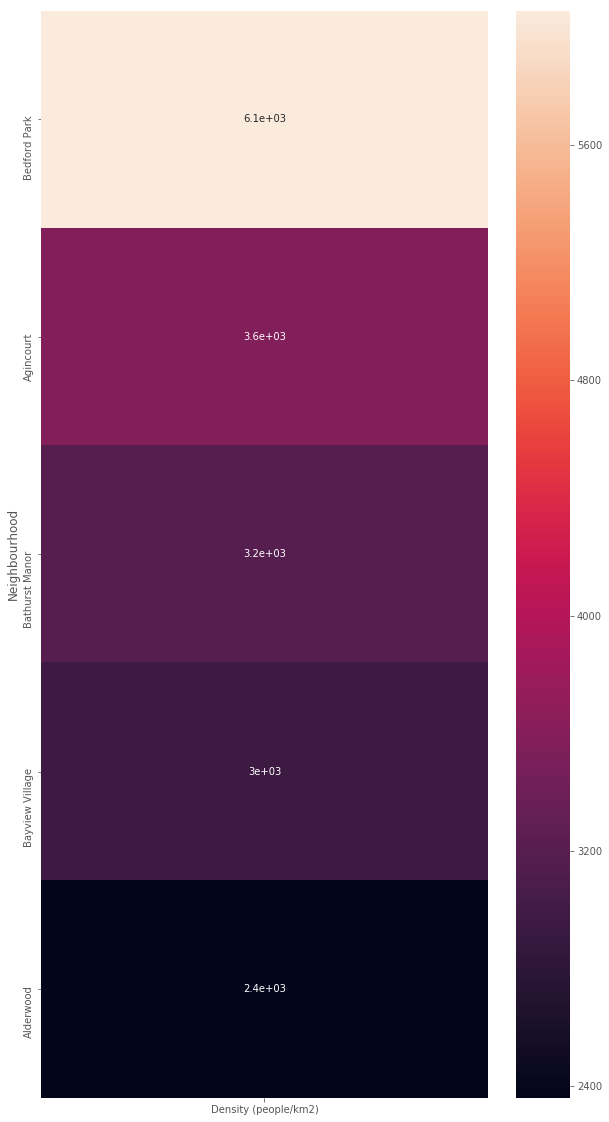

In [38]:
%matplotlib inline

from matplotlib import pyplot
df = Toronto_Demographics[['Neighbourhood', 'Density (people/km2)']][0:5]
df = df.sort_values(['Density (people/km2)'], ascending=False)
df = df.set_index(keys=['Neighbourhood'])
df = df.apply(pd.to_numeric, errors='ignore')
a4_dims = (10, 20)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, annot=True)
plt.show()

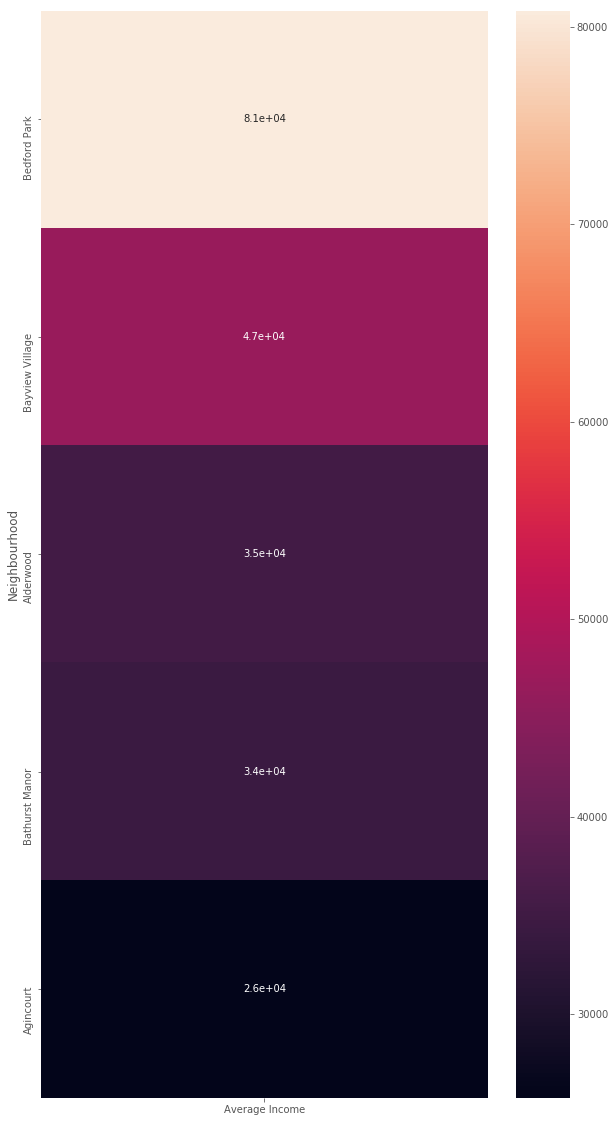

In [39]:

df = Toronto_Demographics[['Neighbourhood', 'Average Income']][0:5]
df = df.sort_values(['Average Income'], ascending=False)
df = df.set_index(keys=['Neighbourhood'])
df = df.apply(pd.to_numeric, errors='ignore')
a4_dims = (10, 20)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, annot=True)
plt.show()

In [40]:

!conda install -c conda-forge seaborn --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.9.0              |             py_0         159 KB  conda-forge

The following packages will be UPDATED:

    seaborn: 0.8.1-py36hfad7ec4_0 --> 0.9.0-py_0 conda-forge


seaborn-0.9.0        | 159 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


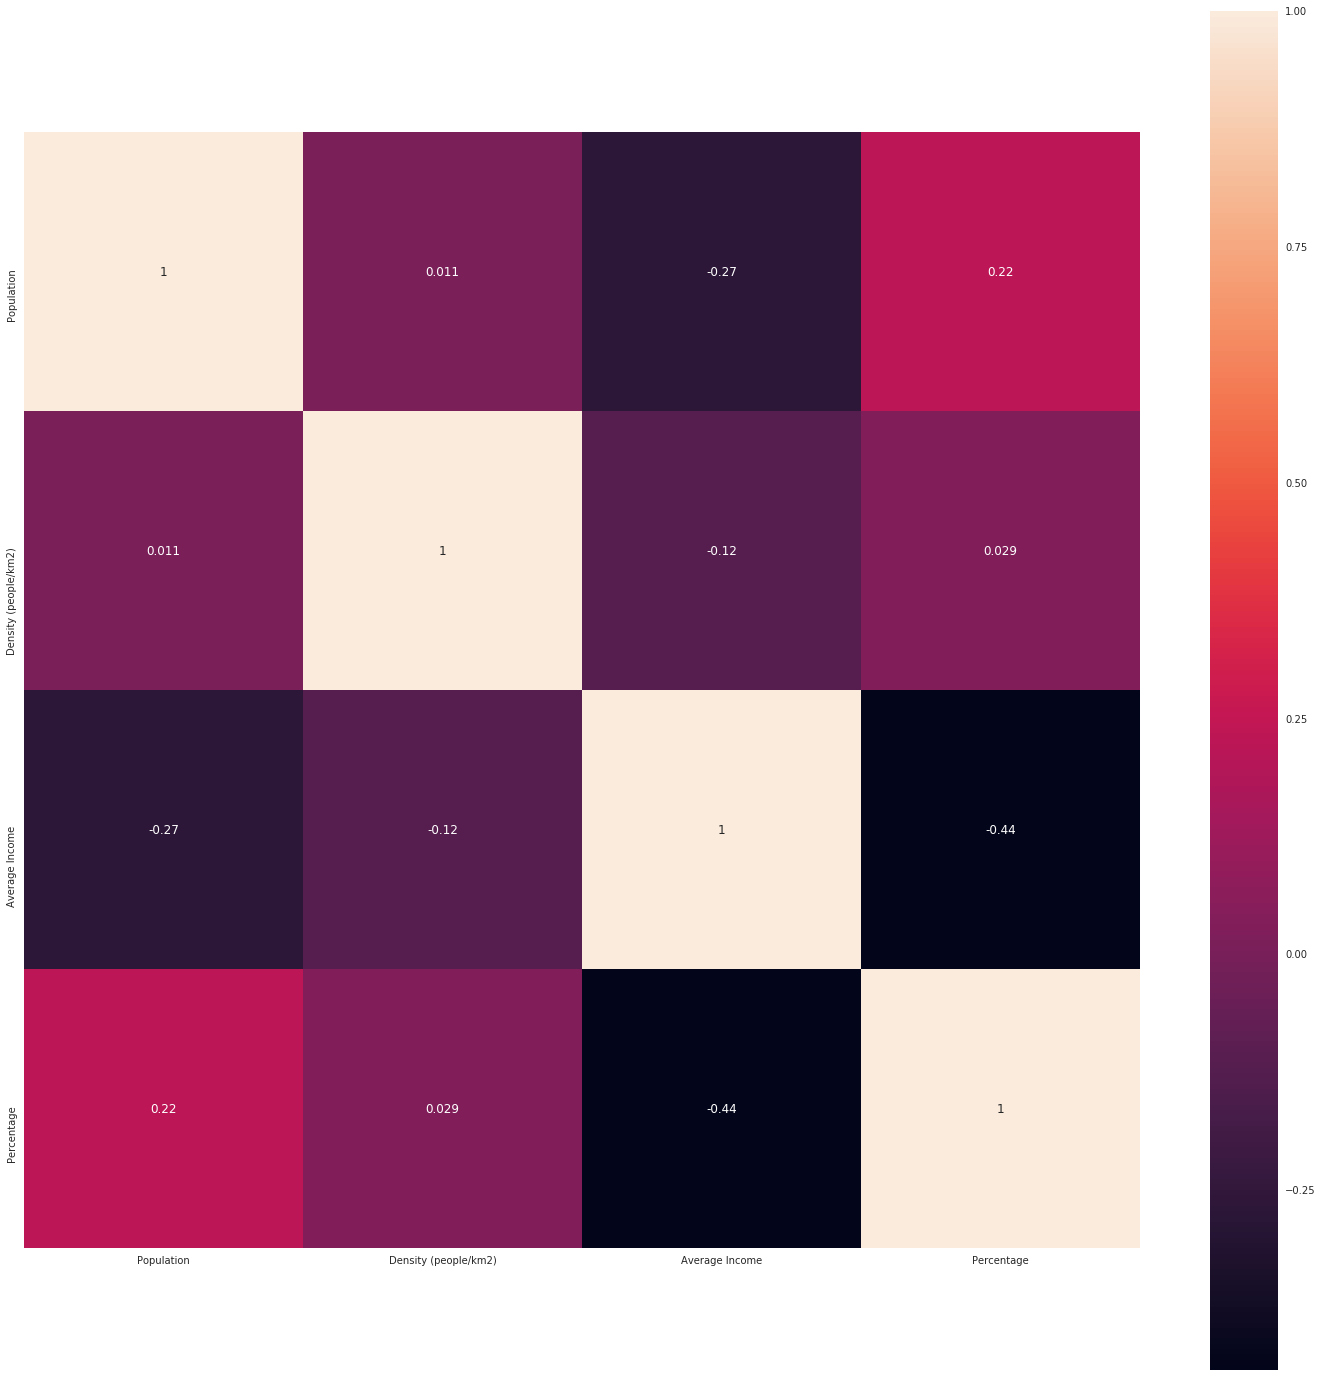

In [41]:
import seaborn as sns
sns.set(style='darkgrid')
df = Toronto_Demographics
df = df.sort_values(['Average Income'], ascending=False)
df = df.set_index(keys=['Neighbourhood'])
df = df.apply(pd.to_numeric, errors='ignore')
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.float)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
a4_dims = (25, 25)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(corr, ax=ax, annot=True, square=True)

In [42]:
Toronto_Merged = pd.merge(Toronto, Toronto_Demographics, on='Neighbourhood')

In [43]:
Toronto_Merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,03.4,Unspecified Chinese
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,3612,29657,03.2,Urdu
2,M6A,North York,Lawrence Heights,43.718518,-79.464763,3769,1178,29867,15.0,Italian
3,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
4,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil


In [44]:
Toronto_Merged.drop_duplicates(keep='first', inplace=True)

In [45]:
Toronto_Merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,03.4,Unspecified Chinese
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,3612,29657,03.2,Urdu
2,M6A,North York,Lawrence Heights,43.718518,-79.464763,3769,1178,29867,15.0,Italian
3,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
4,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil
5,M1B,Scarborough,Malvern,43.806686,-79.194353,44324,5003,25677,12.2,Tamil
6,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,8240,15846,37614,03.0,Unspecified Chinese
7,M9B,Etobicoke,Princess Gardens,43.650943,-79.554724,9288,2249,80607,02.4,Korean
8,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian
9,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12853,2505,33640,05.1,Tamil


In [46]:
Toronto_Merged.shape

(79, 10)

In [47]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
T_lat = location.latitude
T_lon = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(T_lat, T_lon))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


In [48]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

In [49]:
CLIENT_ID = '23DB3QXW1DBU3D4DZSWG02LAG0JHJ1V010GUOPGP1WO3OXTR'
CLIENT_SECRET = 'QWGHM2RUOI4NGXHBWM2FBAMQYAANHMRL5B0RBEX1YFDNHLMZ'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 23DB3QXW1DBU3D4DZSWG02LAG0JHJ1V010GUOPGP1WO3OXTR
CLIENT_SECRET:QWGHM2RUOI4NGXHBWM2FBAMQYAANHMRL5B0RBEX1YFDNHLMZ


<h2> Target Demographics Specific to Filipino Speaking Population

In [50]:
df_fil = Toronto_Merged[Toronto_Merged.Language == 'Filipino']
df_fil = df_fil.sort_values(by=['Percentage','Population'], ascending=False)
df_fil.reset_index(drop=True)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,14666,63765,22341,08.1,Filipino
1,M4X,Downtown Toronto,St. James Town,43.667967,-79.367675,14666,63765,22341,08.1,Filipino
2,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
3,M1K,Scarborough,Ionview,43.727929,-79.262029,13025,6714,25078,06.5,Filipino
4,M3H,North York,Wilson Heights,43.754328,-79.442259,13732,3317,37978,06.2,Filipino
5,M1R,Scarborough,Wexford,43.750071,-79.295849,17844,2239,28556,04.5,Filipino
6,M1L,Scarborough,Clairlea,43.711112,-79.284577,11104,3102,33392,04.3,Filipino
7,M1R,Scarborough,Maryvale,43.750071,-79.295849,8800,3860,30944,04.1,Filipino
8,M1C,Scarborough,Rouge Hill,43.784535,-79.160497,11167,2878,32858,02.4,Filipino
9,M1C,Scarborough,Port Union,43.784535,-79.160497,12450,2310,48117,01.6,Filipino


In [51]:
fil_lat = df_fil['Latitude'].values[0] # neighborhood latitude value
fil_lon = df_fil['Longitude'].values[0] # neighborhood longitude value
fil_name = df_fil['Neighbourhood'].values[0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(fil_name, 
                                                               fil_lat, 
                                                               fil_lon))

Latitude and longitude values of St. James Town are 43.6514939, -79.3754179.


In [52]:

radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    fil_lat, 
    fil_lon, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=23DB3QXW1DBU3D4DZSWG02LAG0JHJ1V010GUOPGP1WO3OXTR&client_secret=QWGHM2RUOI4NGXHBWM2FBAMQYAANHMRL5B0RBEX1YFDNHLMZ&v=20180605&ll=43.6514939,-79.3754179&radius=500&limit=100'

In [53]:
results = requests.get(url).json()
# results
if results != None:
    print("Request successfully processed")

Request successfully processed


In [54]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [55]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Terroni,Italian Restaurant,43.650927,-79.375602
1,Gyu-Kaku Japanese BBQ,Japanese Restaurant,43.651422,-79.375047
2,GEORGE Restaurant,Restaurant,43.653346,-79.374445
3,Fahrenheit Coffee,Coffee Shop,43.652384,-79.372719
4,Triple A Bar (AAA),BBQ Joint,43.651658,-79.372720


In [56]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [58]:
fil_venues = getNearbyVenues(names=df_fil['Neighbourhood'],
                                   latitudes=df_fil['Latitude'],
                                   longitudes=df_fil['Longitude']
                                  )

St. James Town
St. James Town
Lawrence Manor
Ionview
Wilson Heights
Wexford
Clairlea
Maryvale
Rouge Hill
Port Union


<h2> Identify the most common industry/type of business in the neighborhood with the most number of Filipino speaking population

In [59]:
print(fil_venues.shape)
fil_venues.head()

(213, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. James Town,43.651494,-79.375418,Terroni,43.650927,-79.375602,Italian Restaurant
1,St. James Town,43.651494,-79.375418,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant
2,St. James Town,43.651494,-79.375418,GEORGE Restaurant,43.653346,-79.374445,Restaurant
3,St. James Town,43.651494,-79.375418,Fahrenheit Coffee,43.652384,-79.372719,Coffee Shop
4,St. James Town,43.651494,-79.375418,Triple A Bar (AAA),43.651658,-79.372720,BBQ Joint


In [60]:
fil_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. James Town,43.651494,-79.375418,Terroni,43.650927,-79.375602,Italian Restaurant
1,St. James Town,43.651494,-79.375418,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant
2,St. James Town,43.651494,-79.375418,GEORGE Restaurant,43.653346,-79.374445,Restaurant
3,St. James Town,43.651494,-79.375418,Fahrenheit Coffee,43.652384,-79.372719,Coffee Shop
4,St. James Town,43.651494,-79.375418,Triple A Bar (AAA),43.651658,-79.372720,BBQ Joint
5,St. James Town,43.651494,-79.375418,Pearl Diver,43.651481,-79.373600,Gastropub
6,St. James Town,43.651494,-79.375418,Aveda Institute Toronto,43.650096,-79.373630,Cosmetics Shop
7,St. James Town,43.651494,-79.375418,Crepe TO,43.650063,-79.374587,Creperie
8,St. James Town,43.651494,-79.375418,Mystic Muffin,43.652484,-79.372655,Middle Eastern Restaurant
9,St. James Town,43.651494,-79.375418,St James Anglican Cathedral,43.650110,-79.374292,Church


In [61]:
fil_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Clairlea,10,10,10,10,10,10
Ionview,6,6,6,6,6,6
Lawrence Manor,12,12,12,12,12,12
Maryvale,7,7,7,7,7,7
Port Union,2,2,2,2,2,2
Rouge Hill,2,2,2,2,2,2
St. James Town,150,150,150,150,150,150
Wexford,7,7,7,7,7,7
Wilson Heights,17,17,17,17,17,17


In [62]:
print('There are {} uniques categories.'.format(len(fil_venues['Venue Category'].unique())))

There are 99 uniques categories.


In [63]:
# one hot encoding
fil_onehot = pd.get_dummies(fil_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
fil_onehot['Neighborhood'] = fil_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [fil_onehot.columns[-1]] + list(fil_onehot.columns[:-1])
fil_onehot = fil_onehot[fixed_columns]

fil_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arts & Crafts Store,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Bus Line,Bus Station,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Diner,Discount Store,Electronics Store,Event Space,Farmers Market,Flower Shop,Food Truck,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Market,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Movie Theater,New American Restaurant,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Poke Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Thai Restaurant,Theater,Train Station,Video Store,Vietnamese Restaurant,Women's Store
0,St. James Town,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,St. James Town,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,St. James Town,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,St. James Town,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,St. James Town,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
fil_onehot.shape

(213, 100)

In [65]:
fil_grouped = fil_onehot.groupby('Neighborhood').mean().reset_index()
fil_grouped

,Neighborhood,Accessories Store,American Restaurant,Arts & Crafts Store,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Bus Line,Bus Station,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Diner,Discount Store,Electronics Store,Event Space,Farmers Market,Flower Shop,Food Truck,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Market,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Movie Theater,New American Restaurant,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Poke Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Thai Restaurant,Theater,Train Station,Video Store,Vietnamese Restaurant,Women's Store
0,Clairlea,0.000000,0.00,0.000000,0.000000,0.000000,0.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.100000,0.00,0.1,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Ionview,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.166667,0.000000,0.000000,0.166667,0.00,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000
2,Lawrence Manor,0.083333,0.00,0.083333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.00,0.083333,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000
3,Maryvale,0.000000,0.00,0.000000,0.142857,0.000000,0.142857,0.000000,0.0,0.000000,0.000000,0.000000,0.

In [66]:
fil_grouped.shape

(9, 100)

In [67]:
fil_stats = fil_grouped.describe()
fil_stats

,Accessories Store,American Restaurant,Arts & Crafts Store,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Bus Line,Bus Station,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Diner,Discount Store,Electronics Store,Event Space,Farmers Market,Flower Shop,Food Truck,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Market,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Movie Theater,New American Restaurant,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Poke Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Thai Restaurant,Theater,Train Station,Video Store,Vietnamese Restaurant,Women's Store
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.009259,0.002222,0.009259,0.031746,0.001481,0.057672,0.007277,0.111111,0.001481,0.000741,0.000741,0.009259,0.033968,0.006536,0.022222,0.011111,0.000741,0.005926,0.000741,0.001481,0.000741,0.000741,0.020741,0.002222,0.048998,0.000741,0.000741,0.018519,0.002222,0.000741,0.007277,0.019259,0.008758,0.037037,0.000741,0.009259,0.002222,0.000741,0.000741,0.000741,0.006536,0.006536,0.019259,0.002963,0.000741,0.000741,0.010000,0.000741,0.001481,0.001481,0.111111,0.000741,0.003704,0.018388,0.002222,0.011111,0.002963,0.002222,0.000741,0.000741,0.000741,0.000741,0.000741,0.000741,0.011111,0.039023,0.009259,0.000741,0.000741,0.000741,0.000741,0.031746,0.015556,0.000741,0.000741,0.007277,0.009499,0.000741,0.000741,0.002222,0.013943,0.000741,0.039023,0.001481,0.038282,0.000741,0.000741,0.011111,0.000741,0.000741,0.006536,0.000741,0.000741,0.001481,0.000741,0.018519,0.006536,0.009259,0.000741
std,0.027778,0.006667,0.027778,0.062994,0.004444,0.080617,0.019455,0.220479,0.004444,0.002222,0.002222,0.027778,0.062080,0.019608,0.066667,0.033333,0.002222,0.017778,0.002222,0.004444,0.002222,0.002222,0.055121,0.006667,0.063575,0.002222,0.002222,0.055556,0.006667,0.002222,0.019455,0.055322,0.019906,0.111111,0.002222,0.027778,0.006667,0.002222,0.002222,0.002222,0.019608,0.019608,0.055322,0.008889,0.002222,0.002222,0.027588,0.002222,0.004444,0.004444,0.220479,0.002222,0.011111,0.036162,0.006667,0.033333,0.008889,0.006667,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.033333,0.061863,0.027778,0.002222,0.002222,0.002222,0.002222,0.062994,0.034319,0.002222,0.002222,0.019455,0.020492,0.002222,0.002222,0.006667,0.027737,0.002222,0.061863,0.004444,0.062337,0.002222,0.002222,0.033333,0.002222,0.002222,0.019608,0.002222,0

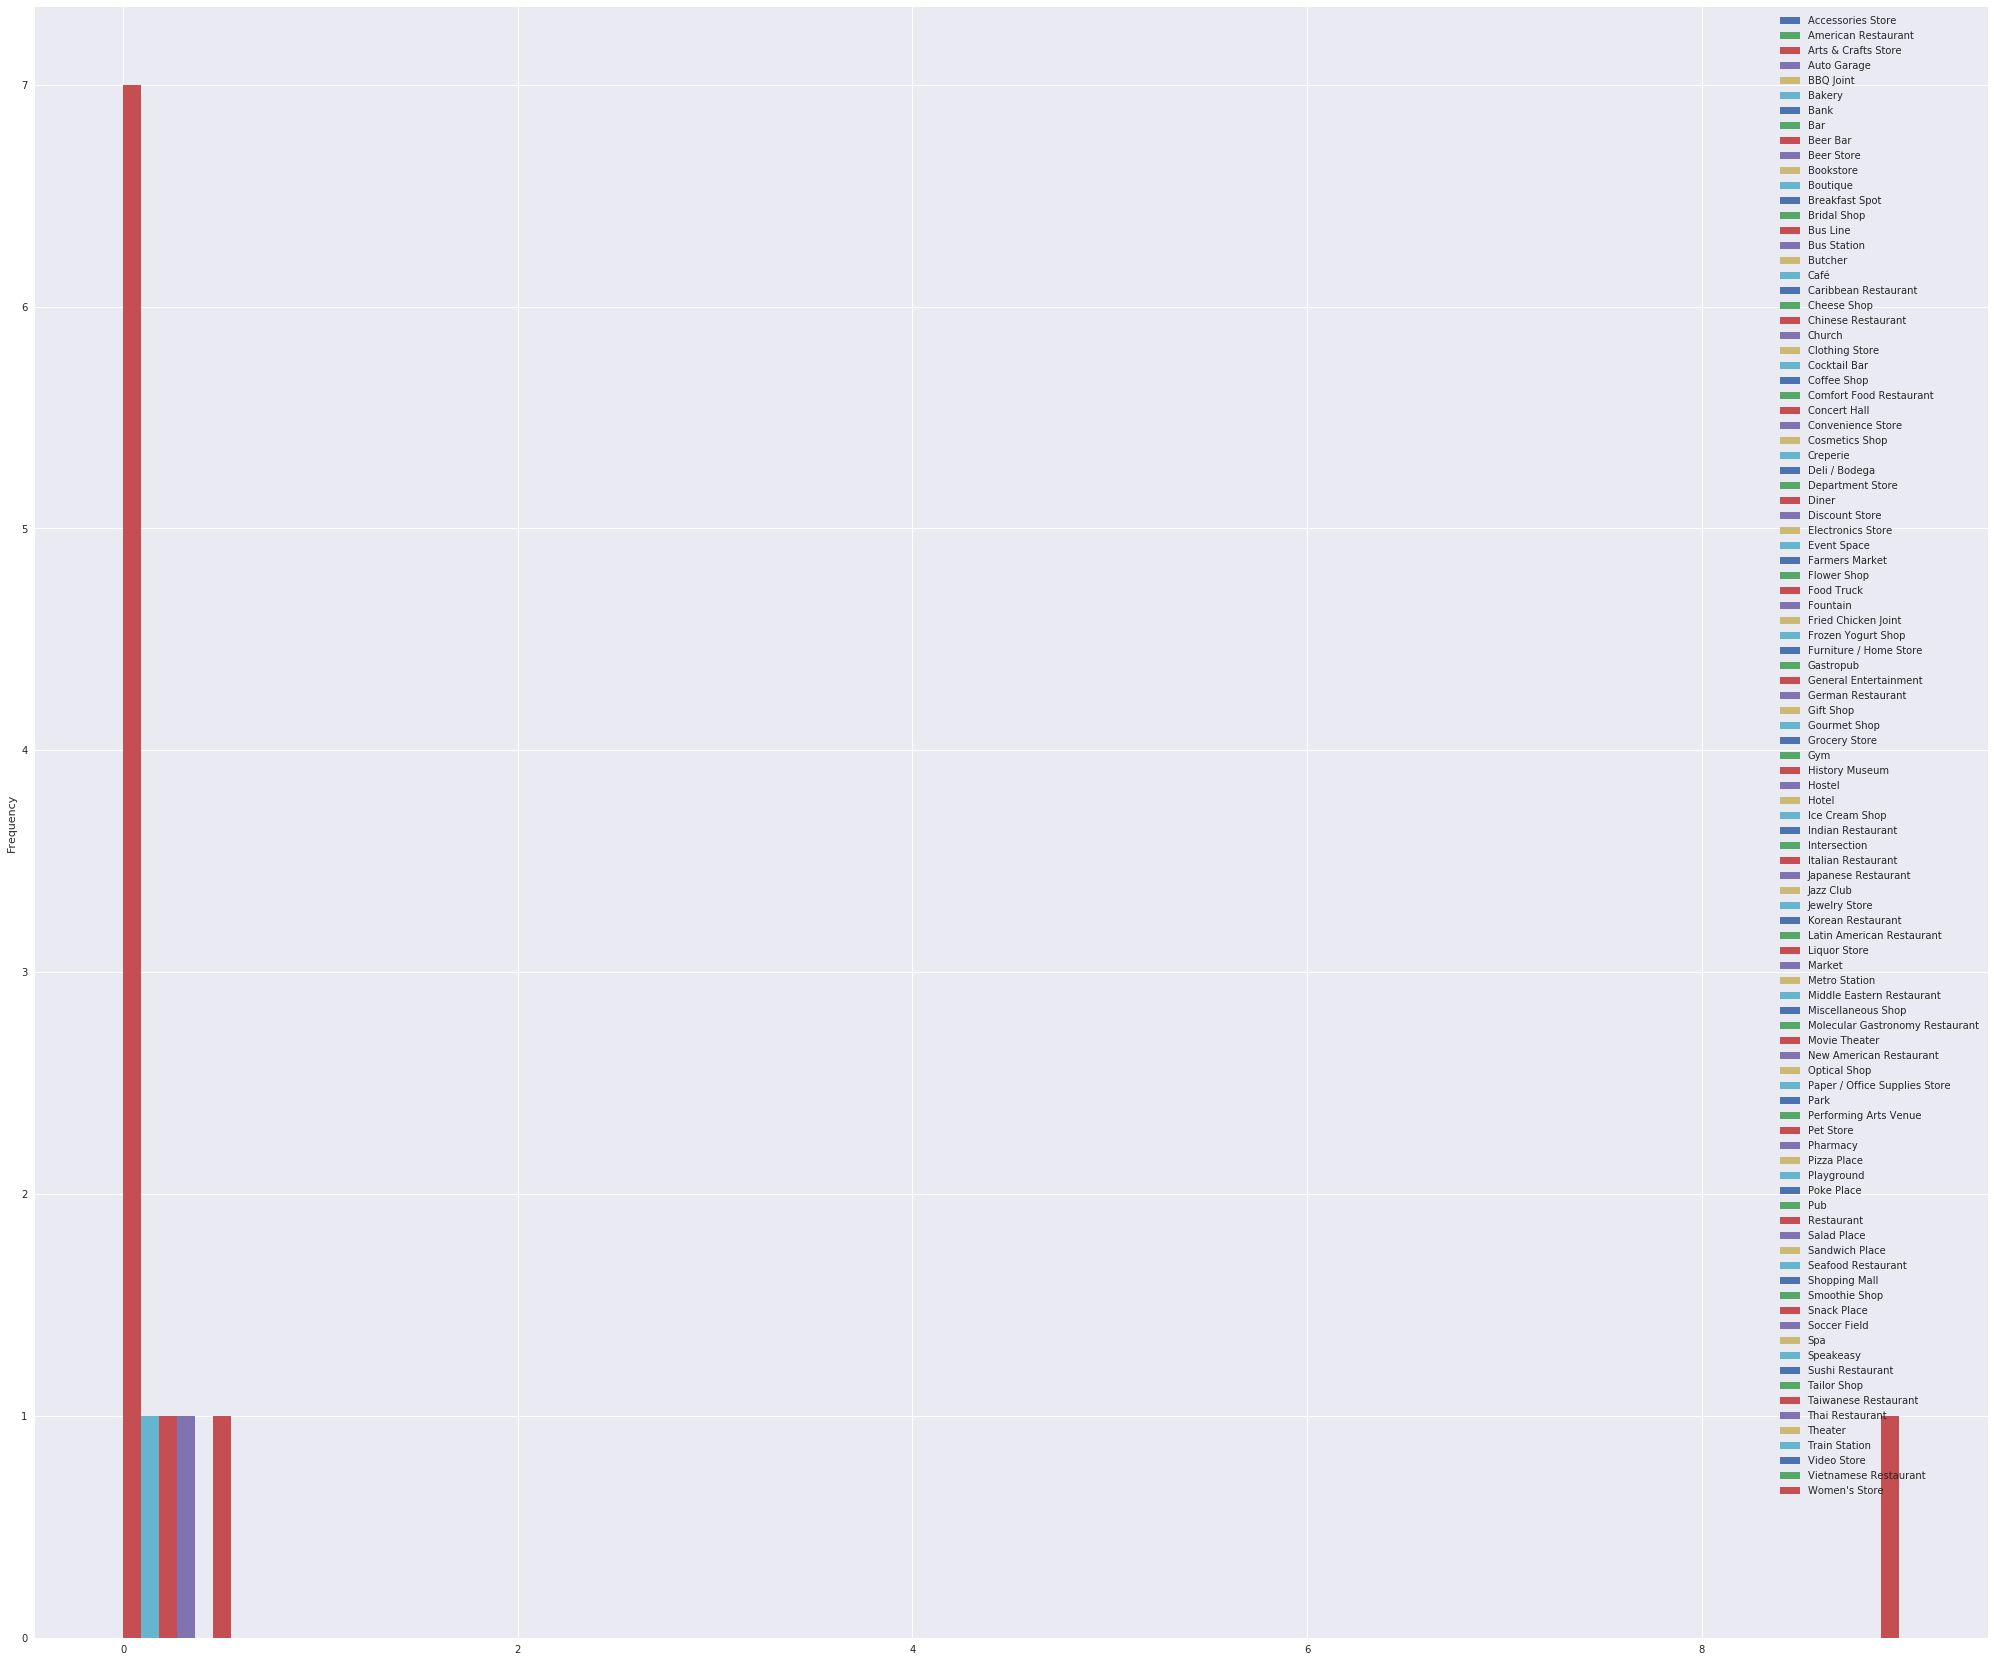

In [68]:
fil_stats.plot.hist(bins=fil_stats.shape[1], figsize=(35,30))
plt.legend(loc='upper right')
plt.show()

            venue  freq
0          Bakery   0.2
1        Bus Line   0.2
2    Soccer Field   0.1
3  Ice Cream Shop   0.1
4            Park   0.1


               venue  freq
0     Discount Store  0.33
1        Coffee Shop  0.17
2      Train Station  0.17
3   Department Store  0.17
4  Convenience Store  0.17


                    venue  freq
0  Furniture / Home Store  0.17
1          Clothing Store  0.17
2               Gift Shop  0.08
3             Coffee Shop  0.08
4             Event Space  0.08


                           venue  freq
0                    Auto Garage  0.14
1  Paper / Office Supplies Store  0.14
2                         Bakery  0.14
3                 Sandwich Place  0.14
4                 Breakfast Spot  0.14


                   venue  freq
0         History Museum   0.5
1                    Bar   0.5
2                 Market   0.0
3  Performing Arts Venue   0.0
4                   Park   0.0


                   venue  freq
0         History Museum   0.5
1         

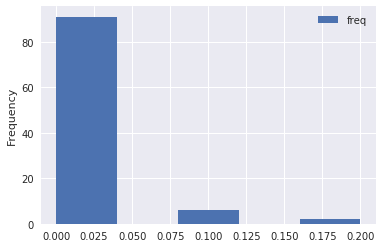

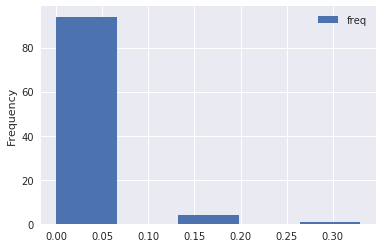

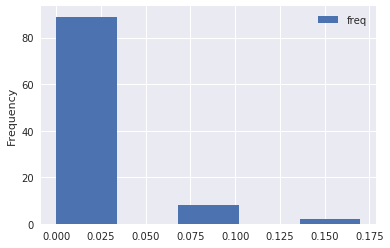

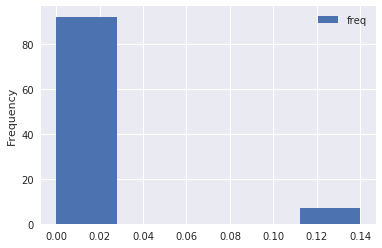

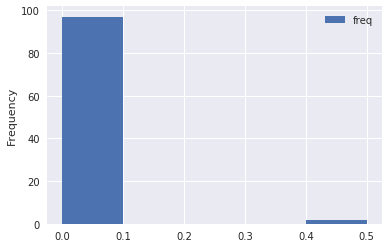

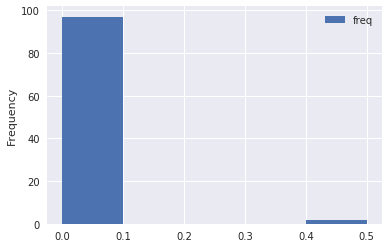

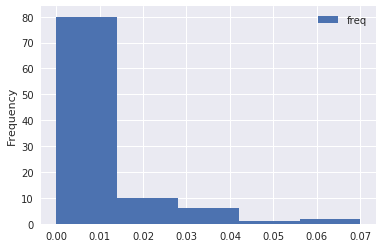

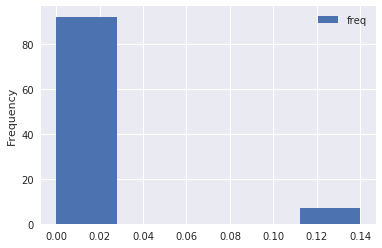

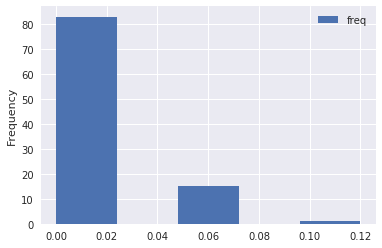

In [69]:
num_top_venues = 5

for hood in fil_grouped['Neighborhood']:
    temp = fil_grouped[fil_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp.plot.hist(bins=5)
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def return_least_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
num_most_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of bottom venues
columns = ['Neighborhood']
for ind in np.arange(num_most_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = fil_grouped['Neighborhood']

for ind in np.arange(fil_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(fil_grouped.iloc[ind, :], num_most_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Clairlea,Bus Line,Bakery,Park,Metro Station,Ice Cream Shop,Intersection,Soccer Field,Bus Station,Convenience Store,Cosmetics Shop
1,Ionview,Discount Store,Train Station,Convenience Store,Department Store,Coffee Shop,Women's Store,Event Space,Concert Hall,Cosmetics Shop,Creperie
2,Lawrence Manor,Furniture / Home Store,Clothing Store,Accessories Store,Boutique,Gift Shop,Event Space,Miscellaneous Shop,Coffee Shop,Vietnamese Restaurant,Arts & Crafts Store
3,Maryvale,Shopping Mall,Bakery,Middle Eastern Restaurant,Sandwich Place,Breakfast Spot,Paper / Office Supplies Store,Auto Garage,Furniture / Home Store,Discount Store,Concert Hall
4,Port Union,History Museum,Bar,Women's Store,Farmers Market,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Diner
5,Rouge Hill,History Museum,Bar,Women's Store,Farmers Market,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Diner
6,St. James Town,Coffee Shop,Restaurant,Café,Park,Hotel,Bakery,Italian Restaurant,Gastropub,Pizza Place,American Restaurant
7,Wexford,Shopping Mall,Bakery,Middle Eastern Restaurant,Sandwich Place,Breakfast Spot,Paper / Office Supplies Store,Auto Garage,Furniture / Home Store,Discount Store,Concert Hall
8,Wilson Heights,Coffee Shop,Middle Eastern Restaurant,Pizza Place,Bridal Shop,Restaurant,Pharmacy,Sandwich Place,Shopping Mall,Deli / Bodega,Ice Cream Shop


In [72]:
num_least_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of bottom venues
columns = ['Neighborhood']
for ind in np.arange(num_least_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_least = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_least['Neighborhood'] = fil_grouped['Neighborhood']

for ind in np.arange(fil_grouped.shape[0]):
    neighborhoods_venues_sorted_least.iloc[ind, 1:] = return_least_common_venues(fil_grouped.iloc[ind, :], num_least_venues)

neighborhoods_venues_sorted_least

,Neighborhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Clairlea,Accessories Store,Optical Shop,New American Restaurant,Movie Theater,Molecular Gastronomy Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Market,Liquor Store,Latin American Restaurant
1,Ionview,Accessories Store,Optical Shop,New American Restaurant,Movie Theater,Molecular Gastronomy Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station,Market,Liquor Store
2,Lawrence Manor,Gym,Paper / Office Supplies Store,Optical Shop,New American Restaurant,Movie Theater,Molecular Gastronomy Restaurant,Middle Eastern Restaurant,Metro Station,Market,Liquor Store
3,Maryvale,Accessories Store,New American Restaurant,Movie Theater,Molecular Gastronomy Restaurant,Miscellaneous Shop,Metro Station,Market,Liquor Store,Latin American Restaurant,Korean Restaurant
4,Port Union,Accessories Store,Paper / Office Supplies Store,Optical Shop,New American Restaurant,Movie Theater,Molecular Gastronomy Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station,Market
5,Rouge Hill,Accessories Store,Paper / Office Supplies Store,Optical Shop,New American Restaurant,Movie Theater,Molecular Gastronomy Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station,Market
6,St. James Town,Accessories Store,Intersection,Frozen Yogurt Shop,Fried Chicken Joint,Metro Station,Event Space,Miscellaneous Shop,Discount Store,Paper / Office Supplies Store,Convenience Store
7,Wexford,Accessories Store,New American Restaurant,Movie Theater,Molecular Gastronomy Restaurant,Miscellaneous Shop,Metro Station,Market,Liquor Store,Latin American Restaurant,Korean Restaurant
8,Wilson Heights,Accessories Store,Miscellaneous Shop,Metro Station,Market,Liquor Store,Latin American Restaurant,Korean Restaurant,Jewelry Store,Jazz Club,Molecular Gastronomy Restaurant


In [74]:
DT_lon = Downtown ['Longitude'].values[1] # neighborhood longitude value

DT_lat = Downtown ['Latitude'].values[1] # neighborhood latitude value

DT_name = Downtown ['Neighbourhood'].values[1] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(DT_name, 
                                                               DT_lat, 
                                                               DT_lon))

Latitude and longitude values of St. James Town are 43.6514939, -79.3754179.


In [75]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    DT_lat, 
    DT_lon, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=23DB3QXW1DBU3D4DZSWG02LAG0JHJ1V010GUOPGP1WO3OXTR&client_secret=QWGHM2RUOI4NGXHBWM2FBAMQYAANHMRL5B0RBEX1YFDNHLMZ&v=20180605&ll=43.6514939,-79.3754179&radius=500&limit=100'

In [76]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [77]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Terroni,Italian Restaurant,43.650927,-79.375602
1,Gyu-Kaku Japanese BBQ,Japanese Restaurant,43.651422,-79.375047
2,GEORGE Restaurant,Restaurant,43.653346,-79.374445
3,Fahrenheit Coffee,Coffee Shop,43.652384,-79.372719
4,Triple A Bar (AAA),BBQ Joint,43.651658,-79.372720


In [78]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [79]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [80]:
DT_venues = getNearbyVenues(names=Downtown['Neighbourhood'],
                                   latitudes=Downtown['Latitude'],
                                   longitudes=Downtown['Longitude']
                                  )

Garden District
St. James Town
Toronto Islands
Grange Park
Kensington Market
Rosedale
Cabbagetown
St. James Town
Church and Wellesley


In [81]:
print(DT_venues.shape)
DT_venues.head()

(692, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Garden District,43.657162,-79.378937,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store
1,Garden District,43.657162,-79.378937,Burrito Boyz,43.656265,-79.378343,Burrito Place
2,Garden District,43.657162,-79.378937,Silver Snail Comics,43.657031,-79.381403,Comic Shop
3,Garden District,43.657162,-79.378937,Blaze Pizza,43.656518,-79.380015,Pizza Place
4,Garden District,43.657162,-79.378937,Yonge-Dundas Square,43.656125,-79.380622,Plaza


In [82]:
DT_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Cabbagetown,50,50,50,50,50,50
Church and Wellesley,88,88,88,88,88,88
Garden District,100,100,100,100,100,100
Grange Park,100,100,100,100,100,100
Kensington Market,100,100,100,100,100,100
Rosedale,4,4,4,4,4,4
St. James Town,150,150,150,150,150,150
Toronto Islands,100,100,100,100,100,100


In [83]:
print('There are {} uniques categories.'.format(len(DT_venues['Venue Category'].unique())))

There are 172 uniques categories.


In [84]:
# one hot encoding
DT_onehot = pd.get_dummies(DT_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DT_onehot['Neighborhood'] = DT_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [DT_onehot.columns[-1]] + list(DT_onehot.columns[:-1])
DT_onehot = DT_onehot[fixed_columns]

DT_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Arts & Crafts Store,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Garden District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Garden District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Garden District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Garden District,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [85]:
DT_onehot.shape

(692, 172)

In [86]:
DT_grouped = DT_onehot.groupby('Neighborhood').mean().reset_index()
DT_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Arts & Crafts Store,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Cabbagetown,0.000000,0.000000,0.000000,0.020000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.040000,0.020000,0.000000,0.00,0.00,0.000000,0.020000,0.00,0.000000,0.020000,0.00,0.000000,0.000000,0.000000,0.020000,0.040000,0.020000,0.000000,0.020000,0.000000,0.00,0.00,0.080000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.00,0.00,0.020000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.02,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.020000,0.000000,0.020000,0.000000,0.020000,0.020000,0.020000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.040000,0.00,0.040000,0.020000,0.000000,0.020000,0.000000,0.00,0.000000,0.00,0.000000,0.020000,0.00,0.020000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.060000,0.000000,0.000000,0.020000,0.020000,0.000000,0.040000,0.020000,0.00,0.000000,0.00,0.040000,0.000000,0.00,0.080000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.020000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.020000,0.00,0.000000,0.020000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000
1,Church and Wellesley,0.011364,0.011364,0.011364,0.011364,0.00,0.00,0.00,0.011364,0.000000,0.00,0.000000,0.000000,0.011364,0.00,0.00,0.000000,0.000000,0.00,0.011364,0.011364,0.00,0.011364,0.045455,0.011364,0.000000,0.022727,0.011364,0.000000,0.011364,0.000000,0.00,0.00,0.068182,0.00,0.000

In [87]:
DT_grouped.shape

(8, 172)

In [88]:
num_top_venues = 5

for hood in DT_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = DT_grouped[DT_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cabbagetown----
               venue  freq
0        Coffee Shop  0.08
1         Restaurant  0.08
2               Park  0.06
3  Indian Restaurant  0.04
4             Bakery  0.04


----Church and Wellesley----
                 venue  freq
0  Japanese Restaurant  0.07
1          Coffee Shop  0.07
2              Gay Bar  0.05
3         Burger Joint  0.05
4     Sushi Restaurant  0.05


----Garden District----
                       venue  freq
0             Clothing Store  0.08
1                Coffee Shop  0.08
2                       Café  0.04
3             Cosmetics Shop  0.04
4  Middle Eastern Restaurant  0.03


----Grange Park----
                           venue  freq
0                           Café  0.08
1                            Bar  0.07
2             Chinese Restaurant  0.05
3  Vegetarian / Vegan Restaurant  0.05
4          Vietnamese Restaurant  0.04


----Kensington Market----
                           venue  freq
0                           Café  0.08
1              

In [89]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [90]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DT_grouped['Neighborhood']

for ind in np.arange(DT_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DT_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cabbagetown,Coffee Shop,Restaurant,Park,Indian Restaurant,Bakery,Pub,Pizza Place,Café,Italian Restaurant,Gastropub
1,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Burger Joint,Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Dance Studio,Café
2,Garden District,Clothing Store,Coffee Shop,Cosmetics Shop,Café,Middle Eastern Restaurant,Japanese Restaurant,Theater,Bar,Sandwich Place,Tea Room
3,Grange Park,Café,Bar,Chinese Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Burger Joint
4,Kensington Market,Café,Bar,Chinese Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Burger Joint
5,Rosedale,Park,Playground,Trail,Women's Store,Falafel Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Filipino Restaurant
6,St. James Town,Coffee Shop,Restaurant,Café,Park,Bakery,Hotel,Gastropub,Italian Restaurant,Pizza Place,Clothing Store
7,Toronto Islands,Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Scenic Lookout,Pizza Place,Brewery,Sports Bar,Restaurant


In [94]:
sjt_latitude = 43.651494 
sjt_longitude = -79.375418
sjt_map = folium.Map(location=[sjt_latitude, sjt_longitude], zoom_start=4000)
sjt_map


In [95]:
DT_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Garden District,43.657162,-79.378937,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store
1,Garden District,43.657162,-79.378937,Burrito Boyz,43.656265,-79.378343,Burrito Place
2,Garden District,43.657162,-79.378937,Silver Snail Comics,43.657031,-79.381403,Comic Shop
3,Garden District,43.657162,-79.378937,Blaze Pizza,43.656518,-79.380015,Pizza Place
4,Garden District,43.657162,-79.378937,Yonge-Dundas Square,43.656125,-79.380622,Plaza
5,Garden District,43.657162,-79.378937,Tacos 101,43.656636,-79.376968,Taco Place
6,Garden District,43.657162,-79.378937,Page One Cafe,43.657772,-79.376073,Café
7,Garden District,43.657162,-79.378937,Salad King,43.657533,-79.381585,Thai Restaurant
8,Garden District,43.657162,-79.378937,Ed Mirvish Theatre,43.655102,-79.379768,Theater
9,Garden District,43.657162,-79.378937,Hokkaido Ramen Santouka らーめん山頭火,43.656435,-79.377586,Ramen Restaurant


<h2> Identify the venue category of businesses in the area with the most number of Filipino speaking individuals in Toronto

In [96]:
import copy

In [97]:
sjt = copy.deepcopy(DT_venues[100:200])

In [98]:
sjt

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
100,St. James Town,43.651494,-79.375418,Terroni,43.650927,-79.375602,Italian Restaurant
101,St. James Town,43.651494,-79.375418,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant
102,St. James Town,43.651494,-79.375418,GEORGE Restaurant,43.653346,-79.374445,Restaurant
103,St. James Town,43.651494,-79.375418,Fahrenheit Coffee,43.652384,-79.372719,Coffee Shop
104,St. James Town,43.651494,-79.375418,Triple A Bar (AAA),43.651658,-79.372720,BBQ Joint
105,St. James Town,43.651494,-79.375418,Pearl Diver,43.651481,-79.373600,Gastropub
106,St. James Town,43.651494,-79.375418,Aveda Institute Toronto,43.650096,-79.373630,Cosmetics Shop
107,St. James Town,43.651494,-79.375418,Crepe TO,43.650063,-79.374587,Creperie
108,St. James Town,43.651494,-79.375418,Mystic Muffin,43.652484,-79.372655,Middle Eastern Restaurant
109,St. James Town,43.651494,-79.375418,St James Anglican Cathedral,43.650110,-79.374292,Church


In [99]:
sjt.to_csv('sjt.csv')

In [100]:
# instantiate a feature group for the St. James Town in the dataframe
sjt_map = folium.map.FeatureGroup()

In [101]:
sjt_map

In [102]:
sjt_lat = 43.651494
sjt_lng = -79.375418
sjt_map = folium.Map(location=[sjt_lat, sjt_lng], zoom_start=1000)

# add markers to map
for lat, lng, venue in zip(sjt['Venue Latitude'], sjt['Venue Longitude'], sjt['Venue']):
    label = '{}, {}'.format(venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(sjt_map)  
    
sjt_map

In [105]:
# reverse ascending
sjt.sort_values('Venue Category', ascending=False)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
186,St. James Town,43.651494,-79.375418,TOPSHOP,43.652251,-79.380221,Women's Store
123,St. James Town,43.651494,-79.375418,Elgin And Winter Garden Theatres,43.653394,-79.378507,Theater
129,St. James Town,43.651494,-79.375418,Sukhothai,43.648487,-79.374547,Thai Restaurant
181,St. James Town,43.651494,-79.375418,Garrison Bespoke,43.648102,-79.376334,Tailor Shop
122,St. James Town,43.651494,-79.375418,Vintage Conservatory,43.652229,-79.373487,Speakeasy
124,St. James Town,43.651494,-79.375418,SweetGrass Spa,43.653433,-79.374121,Spa
146,St. James Town,43.651494,-79.375418,Booster Juice,43.652658,-79.378459,Smoothie Shop
174,St. James Town,43.651494,-79.375418,Buster's Sea Cove,43.648495,-79.371462,Seafood Restaurant
169,St. James Town,43.651494,-79.375418,Market Street Catch,43.648501,-79.371808,Seafood Restaurant
155,St. James Town,43.651494,-79.375418,b.good,43.649450,-79.377304,Salad Place


In [106]:
counts_vc=sjt.groupby('Venue Category')['Venue Category']

counts_vc.count()

Venue Category
American Restaurant                2
BBQ Joint                          2
Bakery                             3
Beer Bar                           2
Bookstore                          1
Breakfast Spot                     2
Café                               6
Cheese Shop                        2
Church                             1
Clothing Store                     3
Cocktail Bar                       3
Coffee Shop                        7
Comfort Food Restaurant            1
Concert Hall                       1
Cosmetics Shop                     3
Creperie                           1
Department Store                   1
Diner                              2
Electronics Store                  1
Farmers Market                     2
Food Truck                         1
Fountain                           1
Furniture / Home Store             1
Gastropub                          3
German Restaurant                  1
Grocery Store                      1
Gym                    

Conclusion after review of business types and volume of businesses:
1. There are many restaurants and dining places. There is no "Filipino Restaurant" in the registry, but "Seafood Restaurant", "Molecular Gastronomy Restaurant", "Restaurant", "Gastropub", "Comfort Food Restaurant", "Food Truck", and "Diner" may serve Filipino food.
2. There is only one grocery store, which may be sufficient to cover the area.
3. The best type of business to introduce in the area that can be put up by and may cater to Filipinos is a web-based and/or app-based registry for foodies, critiques, or bloggers to cater to the clientelle's need to identify food types served in relatively ambiguous-named dining locations such as "Seafood Restaurant", "Molecular Gastronomy Restaurant", "Restaurant", "Gastropub", "Comfort Food Restaurant", "Food Truck", and "Diner". The registry can consolidate the information and may be used as a site guide for people who visit the area.

<h1>End of Project for The Battle of Neighborhoods Capstone. Thank you.